In [1]:
#@title Syllabification library
import re

# Syllabification module.
# A special thanks goes to Simona S., Italian linguist, teacher and friend, without whom this module could never exist.

# This module is used both for building the dataset and for computing metrics.
# IMPORTANT: the #, @ and § characters are used internally to correctly split syllables, the input string should not contain them.

# Splits a string along word boundaries (empty spaces and punctuation marks). If synalepha is True, doesn't split
# words which have a vowel boundary (eg. selva_oscura).
def split_words(str, synalepha=False):
    regex = re.compile(r"""[,.;:"“”«»?—'`‘’\s]*\s+[,.;:"“”«»?—'`‘’\s]*""")
    matches = regex.finditer(str)
    indexes = [0]

    for m in matches:
        begin = (m.start() - 1) if m.start() - 1 > 0 else 0
        end = m.end() + 1
        if _is_split_acceptable(str[begin: end], synalepha):
            indexes.append(begin + 1)

    return [str[i:j] for i,j in zip(indexes, indexes[1:]+[None])]

# Splits a single word into syllables.
def syllabify_word(str):
    return _perform_final_splits(_perform_initial_splits(str))

# Splits a block into words and then into syllables.
def syllabify_block(str, synalepha=False):
    words = split_words(str, synalepha)
    syllables = [syllabify_word(w) for w in words]
    return "#".join(syllables)

# Removes capitalization, punctuation marks and, optionally, diacritics (accents and dieresis).
def prettify(str, keep_diacritics=True):
    if keep_diacritics:
        out = _strip_spaces(_strip_punctuaction(str.lower()))
    else:
        out = _strip_spaces(_strip_punctuaction(_remove_diacritics(str.lower())))
    return out

# Removes hash characters from a string.
def strip_hashes(str):
    return re.sub("#", "", str)

# Determines if a split between two words is acceptable, ie. if there are no synalepha nor elision (eg. "l' amico" should be kept together).
# Heuristic: all apostrophes are considered a non-breakable point. This is not always the case (eg. "perch’ i’ fu’" should be split into "perch’ i’"-"fu’).
def _is_split_acceptable(str, synalepha=False):
    prev = str[0]
    next = str[len(str) - 1]
    vowel = re.compile(r"""[AEIOUaeiouàèéìòóùÈ]""")
    apostrophe = re.compile(r""".*['`‘’].*""")
    newline = re.compile(r""".*\n+.*""")

    out = newline.match(str) or \
          not (apostrophe.match(str) and (vowel.match(prev) or vowel.match(next)))

    if synalepha:
        out = out and not (vowel.match(prev) and vowel.match(next))

    return out

# Removes punctuation from a string.
def _strip_punctuaction(str):
    return re.sub(r"""[,.;:"“”!?«»—'`’]+""", "", str)

# Removes diacritic marks from a string.
def _remove_diacritics(str):
    out = re.sub(r"""[àä]""", "a", str)
    out = re.sub(r"""[èéë]""", "e", out)
    out = re.sub(r"""[ìï]""", "i", out)
    out = re.sub(r"""[òóö]""", "o", out)
    out = re.sub(r"""[ùü]""", "u", out)
    return out

# Removes spaces from a string.
def _strip_spaces(str):
    return re.sub(r"""\s+""", "", str)

# Performs the first (easy and unambiguous) phase of syllabification.
def _perform_initial_splits(str):
    return _split_hiatus(_split_dieresis(_split_double_cons(_split_multiple_cons(str))))

# Performs the second (difficult and heuristic) phase of syllabification.
def _perform_final_splits(str):
    cvcv = r"""(?i)([bcdfglmnpqrstvz][,.;:"“”«»?—'`‘’\s]*[aeiouàèéìóòùÈËÏ]+)([bcdfglmnpqrstvz]+[,.;:"“”«»?—'`‘’\s]*[aeiouàèéìóòùÈËÏ]+)"""
    vcv = r"""(?i)([aeiouàèéìóòùÈËÏ]+)([bcdfglmnpqrstvz]+[,.;:"“”«»?—'`‘’\s]*[aeiouàèéìóòùÈËÏ]+)"""
    vv = r"""(?i)(?<=[aeiouàèéìóòùÈËÏ])(?=[aeiouàèéìóòùÈËÏ])"""

    # Split the contoid vocoid - contoid vocoid case (eg. ca-ne). Deterministic.
    out = re.sub(cvcv, r"""\1#\2""", str)
    # Split the vocoid - contoid vocoid case (eg. ae-reo). Deterministic.
    out = re.sub(vcv, r"""\1#\2""", out)

    # Split the vocoid - vocoid case (eg. a-iuola). Heuristic.
    out = _clump_diphthongs(out)
    out = re.sub(vv, r"""#""", out)
    out = re.sub("§", "", out)

    return out

# Splits double consonants (eg. al-legro)
def _split_double_cons(str):
    doubles = re.compile(r"""(?i)(([bcdfglmnpqrstvz])(?=\2)|c(?=q))""")
    return "#".join(doubles.sub(r"""\1@""", str).split("@"))

# Splits multiple consonants, except: impure s (sc, sg, etc.), mute followed by liquide (eg. tr), digrams and trigrams.
def _split_multiple_cons(str):
    impures = re.compile(r"""(?i)(s(?=[bcdfghlmnpqrtvz]))""")
    muteliquide = re.compile(r"""(?i)([bcdgpt](?=[lr]))""")
    digrams = re.compile(r"""(?i)(g(?=li)|g(?=n[aeiou])|s(?=c[ei])|[cg](?=h[eèéiì])|[cg](?=i[aou]))""")
    trigrams = re.compile(r"""(?i)(g(?=li[aou])|s(?=ci[aou]))""")
    multicons = re.compile(r"""(?i)([bcdfglmnpqrstvz](?=[bcdfglmnpqrstvz]+))""")

    # Preserve non admissibile splits.
    out ="§".join(impures.sub(r"""\1@""", str).split("@"))
    out = "§".join(muteliquide.sub(r"""\1@""", out).split("@"))
    out = "§".join(digrams.sub(r"""\1@""", out).split("@"))
    out = "§".join(trigrams.sub(r"""\1@""", out).split("@"))
    # Split everything else.
    out = "#".join(multicons.sub(r"""\1@""", out).split("@"))

    return "".join(re.split("§", out))

# Splits dieresis.
def _split_dieresis(str):
    dieresis = re.compile(r"""(?i)([äëïöüËÏ](?=[aeiou])|[aeiou](?=[äëïöüËÏ]))""")
    return "#".join(dieresis.sub(r"""\1@""", str).split("@"))

# Splits SURE hiatuses only. Ambiguous ones are heuristically considered diphthongs.
def _split_hiatus(str):
    hiatus = re.compile(r"""(?i)([aeoàèòóé](?=[aeoàèòóé])|[rb]i(?=[aeou])|tri(?=[aeou])|[ìù](?=[aeiou]))""")
    return "#".join(hiatus.sub(r"""\1@""", str).split("@"))

# Prevents splitting of diphthongs and triphthongs.
def _clump_diphthongs(str):
    diphthong = r"""(?i)(i[,.;:"“”«»?—'`‘’\s]*[aeouàèéòóù]|u[,.;:"“”«»?—'`‘’\s]*[aeioàèéìòó]|[aeouàèéòóù][,.;:"“”«»?—'`‘’\s]*i|[aeàèé][,.;:"“”«»?—'`‘’\s]*u)"""
    diphthongsep = r"""(\{.[,.;:"“”«»?—'`‘’\s]*)(.\})"""
    triphthong = r"""(?i)(i[àèé]i|u[àòó]i|iu[òó])"""
    triphthongsep = r"""(\{.)(.)(.\})"""

    out = re.sub(triphthong, r"""{\1}""", str)
    out = re.sub(triphthongsep, r"""\1§\2§\3""", out)
    out = re.sub(diphthong, r"""{\1}""", out)
    out = re.sub(diphthongsep, r"""\1§\2""", out)
    out = re.sub(r"""[{}]""", "", out)

    return out

In [2]:
with open('dante-no_punti (3).txt','r') as f:
#with open('inferno_syllnew.txt','r') as f:
  divine_comedy = f.read()

print(divine_comedy[:250])
print('\n\n[...]\n\n')
print(divine_comedy[-280:])

Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura
ché la diritta via era smarrita

Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura

Tant’ è amara che poco è più morte
ma pe


[...]


 come vi s’indova

ma non eran da ciò le proprie penne
se non che la mia mente fu percossa
da un fulgore in che sua voglia venne

A l’alta fantasia qui mancò possa
ma già volgeva il mio disio e ’l velle
sì come rota ch’igualmente è mossa

l’amor che move il sole e l’altre stelle



In [3]:
import re

divine_comedy = divine_comedy.replace("ä", "a")
divine_comedy = divine_comedy.replace("é", "e")
divine_comedy = divine_comedy.replace("è", "e")
divine_comedy = divine_comedy.replace("ë", "e")
divine_comedy = divine_comedy.replace("Ë", "E")
divine_comedy = divine_comedy.replace("ï", "i")
divine_comedy = divine_comedy.replace("Ï", "I")
divine_comedy = divine_comedy.replace("ó", "o")
divine_comedy = divine_comedy.replace("ò", "o")
divine_comedy = divine_comedy.replace("ö", "o")
divine_comedy = divine_comedy.replace("ü", "u")
divine_comedy = divine_comedy.replace("(", "-")
divine_comedy = divine_comedy.replace(")", "-")
divine_comedy = divine_comedy.replace("[", "")
divine_comedy = divine_comedy.replace("]", "")
divine_comedy = re.sub(r'[0-9]+', '', divine_comedy)

In [4]:
dante = syllabify_block(divine_comedy)

In [5]:
print(dante[:250])
print('\n\n[...]\n\n')
print(dante[-280:])

Nel# mez#zo# del# cam#min# di# no#stra# vi#ta#
mi# ri#tro#vai# per# u#na# sel#va# o#scu#ra#
che# la# di#rit#ta# via# e#ra# smar#ri#ta#

Ahi# quan#to# a# dir# qual# e#ra# e# co#sa# du#ra#
e#sta# sel#va# sel#vag#gia# e# a#spra# e# for#te#
che# nel# pen


[...]


# mia# men#te# fu# per#cos#sa#
da# un# ful#go#re# in# che# sua# vo#glia# ven#ne#

A# l’al#ta# fan#ta#sia# qui# man#co# pos#sa#
ma# già# vol#ge#va# il# mio# di#sio# e ’l# vel#le#
sì# co#me# ro#ta# ch’i#gual#men#te# e# mos#sa#

l’a#mor# che# mo#ve# il# so#le# e# l’al#tre# stel#le#



In [6]:
divine_comedy2 = dante.lower()
divine_comedy2 = re.sub('# ','# #',divine_comedy2)
divine_comedy2 = re.sub('\n\n','\n=end_terzine=#\n',divine_comedy2)


divine_comedy_lines = divine_comedy2.split('\n')
print(divine_comedy_lines[0:10])
my_data = []
my_data.append(['=end_terzine='])
for el in divine_comedy_lines:
    el2 = el.strip()
    el3 = el2.split('#')
    if el3[:-1] != []:
      my_data.append(el3[:-1])

       


['nel# #mez#zo# #del# #cam#min# #di# #no#stra# #vi#ta#', 'mi# #ri#tro#vai# #per# #u#na# #sel#va# #o#scu#ra#', 'che# #la# #di#rit#ta# #via# #e#ra# #smar#ri#ta#', '=end_terzine=#', 'ahi# #quan#to# #a# #dir# #qual# #e#ra# #e# #co#sa# #du#ra#', 'e#sta# #sel#va# #sel#vag#gia# #e# #a#spra# #e# #for#te#', 'che# #nel# #pen#sier# #ri#no#va# #la# #pau#ra#', '=end_terzine=#', 'tan#t’ e# #a#ma#ra# #che# #po#co# #e# #più# #mor#te#', 'ma# #per# #trat#tar# #del# #ben# #ch’i’ vi# #tro#vai#']


In [7]:
for i in range(5):
  print(my_data[-i])

['=end_terzine=']
['l’a', 'mor', ' ', 'che', ' ', 'mo', 've', ' ', 'il', ' ', 'so', 'le', ' ', 'e', ' ', 'l’al', 'tre', ' ', 'stel', 'le']
['=end_terzine=']
['sì', ' ', 'co', 'me', ' ', 'ro', 'ta', ' ', 'ch’i', 'gual', 'men', 'te', ' ', 'e', ' ', 'mos', 'sa']
['ma', ' ', 'già', ' ', 'vol', 'ge', 'va', ' ', 'il', ' ', 'mio', ' ', 'di', 'sio', ' ', 'e ’l', ' ', 'vel', 'le']


In [8]:
##############

def string_split(string):
  string_rev = string[::-1]
  #print(string_rev)

  counter = 0
  pos_split = 0

  for i in range(len(string_rev)):
    #print(string_rev[i])
    #print(string_rev[i] in 'aeiou')
    if string_rev[i] in 'aeiou':
      counter += 1
      if counter == 2:
        pos_split = len(string)-1-i
        return pos_split 

  return pos_split 



###################




def convert_3char_last(lista):
  if len(lista)==1:
    return lista

  lista_old = lista[:-2]
  ult = lista[-1]
  penult = lista[-2]


  stringa = penult+ult
  #print(stringa)

  pos = string_split(stringa)
  #print(pos)


  penult_new = stringa[:pos]
  ult_new = stringa[pos:]
  #print(stringa)
  #print(ult_new)
  
  if penult_new != '':
    lista_old.append(penult_new)
  lista_old.append(ult_new)
  

  return lista_old

###################
def syll_trasform(syl1,syl2):

  penult_new = '' 
  ult_new = ''


  syl1_rev = syl1[::-1]
  switch = 0
  for i in range(len(syl1_rev)):
    if switch == 0:

      if syl1_rev[i] in 'aeiou':
        ult_new += syl1_rev[i]
        switch = 1
      else:
        ult_new += syl1_rev[i]

    else:

      penult_new += syl1_rev[i]









  return penult_new[::-1], ult_new[::-1]+syl2

###################
def convert_3char_last_fixed(lista):
  if len(lista)==1:
    return lista

  lista_old = lista[:-2]
  ult = lista[-1]
  penult = lista[-2]

  penult_new, ult_new = syll_trasform(penult,ult)
  #print(stringa)
  #print(ult_new)
  
  if penult_new != '':
    lista_old.append(penult_new)
  lista_old.append(ult_new)
  

  return lista_old


###################
for i in range(100):
  print(convert_3char_last_fixed(my_data[i]))


['=end_terzine=']
['nel', ' ', 'mez', 'zo', ' ', 'del', ' ', 'cam', 'min', ' ', 'di', ' ', 'no', 'stra', ' ', 'v', 'ita']
['mi', ' ', 'ri', 'tro', 'vai', ' ', 'per', ' ', 'u', 'na', ' ', 'sel', 'va', ' ', 'o', 'sc', 'ura']
['che', ' ', 'la', ' ', 'di', 'rit', 'ta', ' ', 'via', ' ', 'e', 'ra', ' ', 'smar', 'r', 'ita']
['=end_terzine=']
['ahi', ' ', 'quan', 'to', ' ', 'a', ' ', 'dir', ' ', 'qual', ' ', 'e', 'ra', ' ', 'e', ' ', 'co', 'sa', ' ', 'd', 'ura']
['e', 'sta', ' ', 'sel', 'va', ' ', 'sel', 'vag', 'gia', ' ', 'e', ' ', 'a', 'spra', ' ', 'e', ' ', 'f', 'orte']
['che', ' ', 'nel', ' ', 'pen', 'sier', ' ', 'ri', 'no', 'va', ' ', 'la', ' ', 'pa', 'ura']
['=end_terzine=']
['tan', 't’ e', ' ', 'a', 'ma', 'ra', ' ', 'che', ' ', 'po', 'co', ' ', 'e', ' ', 'più', ' ', 'm', 'orte']
['ma', ' ', 'per', ' ', 'trat', 'tar', ' ', 'del', ' ', 'ben', ' ', 'ch’i’ vi', ' ', 'tr', 'ovai']
['di', 'ro', ' ', 'de', ' ', 'l’al', 'tre', ' ', 'co', 'se', ' ', 'ch’i’ v’ho', ' ', 'sc', 'orte']
['=end_terzin

In [9]:
my_data2 = []
for i in range(len(my_data)-1):
#for i in range(6):
  #print(convert_3char_last(my_data[i]))
  my_data2.append(convert_3char_last_fixed(my_data[i]))

In [10]:
for i in range(12):
  print(my_data2[i])

['=end_terzine=']
['nel', ' ', 'mez', 'zo', ' ', 'del', ' ', 'cam', 'min', ' ', 'di', ' ', 'no', 'stra', ' ', 'v', 'ita']
['mi', ' ', 'ri', 'tro', 'vai', ' ', 'per', ' ', 'u', 'na', ' ', 'sel', 'va', ' ', 'o', 'sc', 'ura']
['che', ' ', 'la', ' ', 'di', 'rit', 'ta', ' ', 'via', ' ', 'e', 'ra', ' ', 'smar', 'r', 'ita']
['=end_terzine=']
['ahi', ' ', 'quan', 'to', ' ', 'a', ' ', 'dir', ' ', 'qual', ' ', 'e', 'ra', ' ', 'e', ' ', 'co', 'sa', ' ', 'd', 'ura']
['e', 'sta', ' ', 'sel', 'va', ' ', 'sel', 'vag', 'gia', ' ', 'e', ' ', 'a', 'spra', ' ', 'e', ' ', 'f', 'orte']
['che', ' ', 'nel', ' ', 'pen', 'sier', ' ', 'ri', 'no', 'va', ' ', 'la', ' ', 'pa', 'ura']
['=end_terzine=']
['tan', 't’ e', ' ', 'a', 'ma', 'ra', ' ', 'che', ' ', 'po', 'co', ' ', 'e', ' ', 'più', ' ', 'm', 'orte']
['ma', ' ', 'per', ' ', 'trat', 'tar', ' ', 'del', ' ', 'ben', ' ', 'ch’i’ vi', ' ', 'tr', 'ovai']
['di', 'ro', ' ', 'de', ' ', 'l’al', 'tre', ' ', 'co', 'se', ' ', 'ch’i’ v’ho', ' ', 'sc', 'orte']


#REVERSE

In [11]:
def reverse(list): 
    return [ele for ele in reversed(list)] 

my_data2_7 = []
for i in range(len(my_data2)):
  my_data2_7.append(reverse(my_data2[i]))

for i in range(4):
  print(my_data2_7[i])

['=end_terzine=']
['ita', 'v', ' ', 'stra', 'no', ' ', 'di', ' ', 'min', 'cam', ' ', 'del', ' ', 'zo', 'mez', ' ', 'nel']
['ura', 'sc', 'o', ' ', 'va', 'sel', ' ', 'na', 'u', ' ', 'per', ' ', 'vai', 'tro', 'ri', ' ', 'mi']
['ita', 'r', 'smar', ' ', 'ra', 'e', ' ', 'via', ' ', 'ta', 'rit', 'di', ' ', 'la', ' ', 'che']


#END REVERSE

In [12]:
import copy

#my_data3 = copy.deepcopy(my_data2)
my_data3 = copy.deepcopy(my_data2_7)

for i in range(len(my_data3)):
  if len(my_data3[i]) > 1:
    my_data3[i].insert(0, ' -start- ')
    #my_data3[i].insert(0, ' -end- ')
    my_data3[i].append(' -end- ')
    #my_data3[i].append(' -start- ')
    my_data3[i].append('\n')
    
  else:
    my_data3[i].append('\n')

for i in range(12):
  print(my_data3[i])

one_list_data = [item for sublist in my_data3 for item in sublist]
one_list_tokenized = [item for sublist in my_data3 for item in sublist]

['=end_terzine=', '\n']
[' -start- ', 'ita', 'v', ' ', 'stra', 'no', ' ', 'di', ' ', 'min', 'cam', ' ', 'del', ' ', 'zo', 'mez', ' ', 'nel', ' -end- ', '\n']
[' -start- ', 'ura', 'sc', 'o', ' ', 'va', 'sel', ' ', 'na', 'u', ' ', 'per', ' ', 'vai', 'tro', 'ri', ' ', 'mi', ' -end- ', '\n']
[' -start- ', 'ita', 'r', 'smar', ' ', 'ra', 'e', ' ', 'via', ' ', 'ta', 'rit', 'di', ' ', 'la', ' ', 'che', ' -end- ', '\n']
['=end_terzine=', '\n']
[' -start- ', 'ura', 'd', ' ', 'sa', 'co', ' ', 'e', ' ', 'ra', 'e', ' ', 'qual', ' ', 'dir', ' ', 'a', ' ', 'to', 'quan', ' ', 'ahi', ' -end- ', '\n']
[' -start- ', 'orte', 'f', ' ', 'e', ' ', 'spra', 'a', ' ', 'e', ' ', 'gia', 'vag', 'sel', ' ', 'va', 'sel', ' ', 'sta', 'e', ' -end- ', '\n']
[' -start- ', 'ura', 'pa', ' ', 'la', ' ', 'va', 'no', 'ri', ' ', 'sier', 'pen', ' ', 'nel', ' ', 'che', ' -end- ', '\n']
['=end_terzine=', '\n']
[' -start- ', 'orte', 'm', ' ', 'più', ' ', 'e', ' ', 'co', 'po', ' ', 'che', ' ', 'ra', 'ma', 'a', ' ', 't’ e', 'tan', 

In [13]:
print(one_list_data[1:100])
print(repr(one_list_data[-1]))

['\n', ' -start- ', 'ita', 'v', ' ', 'stra', 'no', ' ', 'di', ' ', 'min', 'cam', ' ', 'del', ' ', 'zo', 'mez', ' ', 'nel', ' -end- ', '\n', ' -start- ', 'ura', 'sc', 'o', ' ', 'va', 'sel', ' ', 'na', 'u', ' ', 'per', ' ', 'vai', 'tro', 'ri', ' ', 'mi', ' -end- ', '\n', ' -start- ', 'ita', 'r', 'smar', ' ', 'ra', 'e', ' ', 'via', ' ', 'ta', 'rit', 'di', ' ', 'la', ' ', 'che', ' -end- ', '\n', '=end_terzine=', '\n', ' -start- ', 'ura', 'd', ' ', 'sa', 'co', ' ', 'e', ' ', 'ra', 'e', ' ', 'qual', ' ', 'dir', ' ', 'a', ' ', 'to', 'quan', ' ', 'ahi', ' -end- ', '\n', ' -start- ', 'orte', 'f', ' ', 'e', ' ', 'spra', 'a', ' ', 'e', ' ', 'gia', 'vag']
'\n'


In [14]:
vocab = sorted(set(one_list_data))

syl2idx = {u:i for i, u in enumerate(vocab)}
idx2syl = {i:u for i, u in enumerate(vocab)}

print(syl2idx)
print(idx2syl)

{'\n': 0, ' ': 1, '    e': 2, '   non': 3, '   tal': 4, ' -end- ': 5, ' -start- ': 6, ' a’ dei': 7, ' a’ rai': 8, ' bei': 9, ' biche': 10, ' bue': 11, ' bui': 12, ' caschi': 13, ' ch’io': 14, ' ciechi': 15, ' co': 16, ' cui': 17, ' dei': 18, ' dia': 19, ' diche': 20, ' die': 21, ' die’mi': 22, ' dio': 23, ' due': 24, ' dì': 25, ' ei': 26, ' eschi': 27, ' fai': 28, ' fe': 29, ' fei': 30, ' fiche': 31, ' fie': 32, ' fio': 33, ' fioche': 34, ' fischio': 35, ' fu': 36, ' fue': 37, ' fui': 38, ' fu’mi': 39, ' gia': 40, ' gio': 41, ' guaschi': 42, ' gì': 43, ' ha': 44, ' hai': 45, ' io': 46, ' la': 47, ' lai': 48, ' lei': 49, ' li': 50, ' lo': 51, ' lui': 52, ' lì': 53, ' mai': 54, ' me': 55, ' mei': 56, ' mia': 57, ' mie': 58, ' mio': 59, ' mischio': 60, ' nieghi': 61, ' noi': 62, ' paghi': 63, ' paschi': 64, ' pe': 65, ' pia': 66, ' piaghe': 67, ' pie': 68, ' pieghe': 69, ' pieghi': 70, ' pio': 71, ' più': 72, ' po': 73, ' poche': 74, ' poi': 75, ' puo': 76, ' qui': 77, ' rai': 78, ' re': 

In [15]:
import numpy as np
import tensorflow as tf

one_list_tokenized = np.array([syl2idx[c] for c in one_list_data])

print(one_list_tokenized[1:100])

[   0    6 1728 3524    1 3043 2168    1  886    1 1992  488    1  824
    1 3671 1974    1 2104    5    0    6 3474 2734 2231    1 3525 2817
    1 2076 3406    1 2459    1 3536 3314 2653    1 1978    5    0    6
 1728 2600 2928    1 2602 1048    1 3566    1 3183 2670  886    1 1770
    1  511    5    0  117    0    6 3474  785    1 2712  716    1 1048
    1 2602 1048    1 2571    1  909    1  118    1 3258 2573    1  186
    5    0    6 2386 1314    1 1048    1 2987  118    1 1048    1 1438
 3532]


In [16]:
seq_length = 300
examples_per_epoch = len(one_list_tokenized)//(seq_length+1)


syl_dataset = tf.data.Dataset.from_tensor_slices(one_list_tokenized)

sequences = syl_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)


BATCH_SIZE = 64
batch_size = BATCH_SIZE
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [17]:
from itertools import groupby

def loss_syllable(verses):
  if '\n' not in verses:
    return 100
  #verses = verses[verses.index('\n')+1:verses.rindex('\n')]
  verses = [list(g) for k, g in groupby(verses, key=lambda x: x != "\n") if k]
  #print(verses)
  err = 0.0
  num_verses = 0
  
  for el in verses:
    if ' -start- ' in el and ' -end- ' in el:
      #verso = el[el.index('- start -')+1:el.rindex('- end -')]
      counter = len([  syl  for syl in el if syl != ' ' and syl != ' -start- ' and syl != ' -end- '])
      #print(counter, '     ',  el[1:-1])
      err = err + abs( 11 - counter)
      num_verses += 1
  if num_verses > 0 :
    return err/num_verses
  else:
    return 100


##########################################################################################################################
##########################################################################################################################
##########################################################################################################################
def loss_terzine(verses):

  verses = [list(g) for k, g in groupby(verses, key=lambda x: x != "\n") if k]


  num_terzine = 0
  num_well_formed = 0

  for i in range(len(verses)-4):
    #print(verses[i])
    if verses[i] == ['=end_terzine=']:
      num_terzine += 1
      if verses[i+1] != ['=end_terzine='] and verses[i+2] != ['=end_terzine='] and verses[i+3] != ['=end_terzine='] and verses[i+4] == ['=end_terzine=']:
        num_well_formed += 1


  if num_terzine > 0:
    return num_terzine - num_well_formed
    #return (num_terzine - num_well_formed)/num_terzine
  else:
    return 100

##########################################################################################################################
##########################################################################################################################
##########################################################################################################################

def loss_rhymes(verses):

  verses = [list(g) for k, g in groupby(verses, key=lambda x: x != "\n") if k]




  verses = verses[:-1]

  #for i in range(len(verses)):
    #print(verses[i])


  num_checked_rhymes = 0
  num_good_rhymes = 0

#---------------------------------------------#

  for i in range(len(verses)-3):

    if verses[i] == ['=end_terzine=']:
      a = verses[i+1]
      b = verses[i+3]

      if len(a)==1 or len(b)==1:
        pass
      else:

        if a[1] == b[1]:
          num_checked_rhymes += 1
          num_good_rhymes += 1
        else:
          num_checked_rhymes += 1

#---------------------------------------------#

  for i in range(len(verses)-5):

    if verses[i] == ['=end_terzine=']:
      a = verses[i+2]
      b = verses[i+5]

      if len(a)==1 or len(b)==1:
        pass
      else:

        if a[1] == b[1]:
          num_checked_rhymes += 1
          num_good_rhymes += 1
        else:
          num_checked_rhymes += 1

#---------------------------------------------#

  if num_checked_rhymes > 0:
    return (num_checked_rhymes - num_good_rhymes)/num_checked_rhymes
  else:
    return 10

In [18]:
def loss(labels, logits):

    predicted_id = []
    for j in range(seq_length):


      predicted_id.append(tf.random.categorical(logits[:,j,:], num_samples=1)[-1,0].numpy())
  
      #try:

        #predicted_id.append(tf.random.categorical(logits[:,j,:], num_samples=1)[-1,0].numpy())
      #except:

        #predicted_id.append(tf.random.categorical(logits[:,j,:], num_samples=1)[-1,0].numpy())



    error_syllable = loss_syllable( idx2syl[el] for el in predicted_id )

    #error_terzine = loss_terzine( idx2syl[el] for el in predicted_id )

    error_rhymes = loss_rhymes( idx2syl[el] for el in predicted_id )

    

    #return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)*(1 + error_syllable) #+  error_rhymes

    #return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)*error_syllable #+  error_rhymes

    #return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) + error_syllable #+ error_terzine + error_rhymes
    
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) + error_syllable + 10*error_rhymes
    
    #print(labels)
    #return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) #+ loss_rhymes(idx2char[predicted_id]) + c


In [19]:
import os
from keras.utils import plot_model

# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 512

# Number of RNN units
rnn_units = 1024
# batch size of model
batch_size=BATCH_SIZE
#----------------------------------------------------------------------------------------------

old = True
if old:
      def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
          model = tf.keras.Sequential([
                                       

                                       
              tf.keras.layers.Embedding(vocab_size, embedding_dim,batch_input_shape=[batch_size, None]),

              tf.keras.layers.LSTM(rnn_units,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'),
              tf.keras.layers.LSTM(1024,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'),   

              tf.keras.layers.Dense(512),
              tf.keras.layers.Dropout(0.2),

              tf.keras.layers.Dense(256),
              tf.keras.layers.Dropout(0.2),           
              tf.keras.layers.Dense(vocab_size)



          ])
          return model


model = build_model(
          vocab_size=len(vocab),
          embedding_dim=embedding_dim,
          rnn_units=rnn_units,
          batch_size=BATCH_SIZE)
plot_model(model, show_shapes=True)

model.compile(optimizer='adam', loss=loss, run_eagerly=True)




#----------------------------------------------------------------------------
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_last")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 50

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

tf.train.latest_checkpoint(checkpoint_dir)

Epoch 1/50
15/15 [==============================] - 30s 2s/step - loss: 166.6623
Epoch 2/50
15/15 [==============================] - 24s 2s/step - loss: 120.0118
Epoch 3/50
15/15 [==============================] - 24s 2s/step - loss: 113.8637
Epoch 4/50
15/15 [==============================] - 24s 2s/step - loss: 109.7470
Epoch 5/50
15/15 [==============================] - 24s 2s/step - loss: 103.0345
Epoch 6/50
15/15 [==============================] - 24s 2s/step - loss: 100.4057
Epoch 7/50
15/15 [==============================] - 24s 2s/step - loss: 51.2055
Epoch 8/50
15/15 [==============================] - 24s 2s/step - loss: 66.4033
Epoch 9/50
15/15 [==============================] - 24s 2s/step - loss: 59.8639
Epoch 10/50
15/15 [==============================] - 24s 2s/step - loss: 23.6605
Epoch 11/50
15/15 [==============================] - 24s 2s/step - loss: 75.0786
Epoch 12/50
15/15 [==============================] - 24s 2s/step - loss: 27.9514
Epoch 13/50
15/15 [============

'./training_checkpoints/ckpt_last'

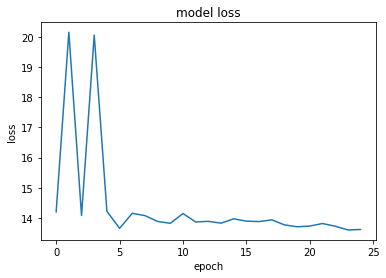

In [20]:
import matplotlib.pyplot as plt

k = 25

plt.plot(history.history['loss'][k:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [21]:
#aaa

tf.train.latest_checkpoint(checkpoint_dir)

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 512)            1952256   
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           6295552   
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 1024)           8392704   
_________________________________________________________________
dense_3 (Dense)              (1, None, 512)            524800    
_________________________________________________________________
dropout_2 (Dropout)          (1, None, 512)            0         
_________________________________________________________________
dense_4 (Dense)              (1, None, 256)            131328    
_________________________________________________________________
dropout_3 (Dropout)          (1, None, 256)           

In [22]:
def generate_text(model, start_string, temperature = 0.5):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 300

    # Converting our start string to numbers (vectorizing)
    input_eval = [syl2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    #temperature = 0.5
    #temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        #print(predictions)
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2syl[predicted_id])
    #print(loss_syllable(start_string + ''.join(text_generated)))
    #print(text_generated)
    return  text_generated

k = 0

start_string = []

for i in range(k,k+4):
  start_string = start_string + my_data3[i]

#start_string.reverse()
print('Seed: ')
print(''.join(start_string))
print()
#start_string=[' -start- ', 'nel',' ','mez','zo',' ','del',' ','cam','min',' ','di',' ','no','stra',' ','vi','ta',' -end- ']
#start_string=[' -start- ', 'che', ' ', 'non', ' ', 'di', 'rò', ' ', 'che', ' ', 'non', ' ', 'si', ' ', 'mo', ' ', 'non', ' ', 'vi', 'ne', ' -end- ']

generated = generate_text(model, start_string=start_string, temperature = 0.6)
print('Generated: ')
gen_reversed = generated
#gen_reversed.reverse()
list_generated = [list(g) for k, g in groupby(generated, key=lambda x: x != "\n") if k]
#print(''.join(gen_reversed))
for i in range(len(list_generated)):
  print(''.join(reverse(list_generated[i])))
#print(generated)
#print(generated[-1])
print()

for i in range(len(list_generated)):
  print(reverse(list_generated[i]))
  #print([list(g) for k, g in groupby(generated, key=lambda x: x != "\n") if k][i])

Seed: 
=end_terzine=
 -start- itav strano di mincam del zomez nel -end- 
 -start- urasco vasel nau per vaitrori mi -end- 
 -start- itarsmar rae via taritdi la che -end- 


Generated: 
=end_terzine=
 -end- sì come si con vedere ad un poco -start- 
 -end- gerine si pria de le gente accorti -start- 
 -end- in satare a li disse e lani indende -start- 
=end_terzine=
 -end- possi che la cesso che da bella -start- 
 -end- e fuor di mente che la sua fiammando -start- 
 -end- e viescia di sua viene al pono onde sosto e in grazia e scende ne la strerga -start- 
 -end- qual vere in forte con la ceri al foco -start- 
=end_terzine=
 -end- e parti e amore indare e di tondo -start- 
 -end- veggendo a colui che ne inno retro -start- 
 -end- che si piete a se stesso e l’ora sira -start- 
=end_terzine=
 -end- quivi mente disse a risisa segno -start- 
 -end- e per leto sa di sì si mio -start- 
era ti rattilla -start- 

['=end_terzine=']
[' -end- ', 'sì', ' ', 'co', 'me', ' ', 'si', ' ', 'con', ' ', 've',

In [ ]:
next = start_string[:-15]
print(''.join(next))
#seed = reverse(next)
seed = reverse([list(g) for k, g in groupby(reverse(next), key=lambda x: x != "\n") if k])


list_generated_verses = []

NUM_VERSES_TO_GENERATE = 150

TEMPERATURE = 0.7

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

for y in range(NUM_VERSES_TO_GENERATE):
    #print([list(g) for k, g in groupby(next, key=lambda x: x != "\n") if k])
    head = [list(g) for k, g in groupby(next, key=lambda x: x != "\n") if k][-1]
    #print(head)
    
    su2 = [list(g) for k, g in groupby(next, key=lambda x: x != "\n") if k][-3]
    su1 = [list(g) for k, g in groupby(next, key=lambda x: x != "\n") if k][-2]
    #print(head[-1])

    #print('next')
    #print(next)
    #print('next')
    generated = generate_text(model, start_string = next, temperature = TEMPERATURE)
    generated = [list(g) for k, g in groupby(generated, key=lambda x: x != "\n") if k]

    if head == ['=end_terzine=']:
      next  = su2 + ['\n'] + su1 + ['\n']  + head + ['\n']
      next_print = reverse(su2) + ['\n'] + reverse(su1) + ['\n']  #+ reverse(head) + ['\n']

    else:
      next  = su2 + ['\n'] + su1 + ['\n']  + head
      next_print = reverse(su2) + ['\n'] + reverse(su1) + ['\n']  #+ reverse(head) 


    
    #generated[0].append('\n')
    #print('LLLLLLLLLLLLLLLL',generated[0])
    next = next + generated[0] + ['\n']
    #next_print =  next_print + reverse(generated[0]) + reverse(head) + ['\n']
    next_print =  reverse(generated[0]) + reverse(head) 


    

    if generated[1] == ['=end_terzine=']:
      next_print.append('\n')
      next_print.append('=end_terzine=')
      next_print.append('\n')

    list_generated_verses.append(next_print)


    #print('++++++++++++++++++++++++++++++++++')
    #print(''.join(reverse(next)))
    print(''.join(next_print))
    print('++++++++++++++++++++++++++++++++++')
    
    if generated[1] == ['=end_terzine=']:
      next.append('=end_terzine=')
      next.append('\n')
      next.append(' -start- ')
      next.append(su1[1])                     # QUI VA INSERITO OUTPUT RETE 2 CHE DA DUE SILLABE IN RIMA
      #next.append(su1[2])
      

    else:
      
      if su2 == ['=end_terzine=']:
        next.append(' -start- ')
        next.append(su1[1])                    # QUI VA INSERITO OUTPUT RETE 2 CHE DA DUE SILLABE IN RIMA
        #next.append(su1[2])
      else:
        next.append(' -start- ')
        #next.append(su2[1])

    
            

    #print(''.join(next))
    #print(next)

    #print('----------------------------')


In [33]:
print('Seed: \n')
for i in range(len(seed)-1):
  print(''.join(seed[i]))
print('--------------------')
for i in range(len(list_generated_verses)):
  print(''.join(list_generated_verses[i]))

Seed: 

=end_terzine=
 -end- nel mezzo del cammin di nostra vita -start- 
 -end- mi ritrovai per una selva oscura -start- 
--------------------
 -end- come a se ne le gradi e smarrita -start- 
=end_terzine=

 -end- ne di cuocer de la fina trilura -start- 
 -end- mi si spinere e fenso ed e morta -start- 
 -end- ciascun che da ciel li che mi dura -start- 
=end_terzine=

 -end- non del viso per che di sol li torta -start- 
 -end- che per cero dire e vero e molto -start- 
 -end- non si volta e l’etterno la porta -start- 
=end_terzine=

 -end- e quante dura andava sì che volto -start- 
 -end- la colpa sorno a bene e quella grea -start- 
 -end- con quelli in lucer tre more e volto -start- 
=end_terzine=

 -end- i voce che ne le scorta che mi fui tutti abbandea -start- 
 -end- la donna fronde per le grata tenne -start- 
 -end- per piedo più di per mente fidea -start- 
=end_terzine=

 -end- noi mi credenza e atto che ti spenne -start- 
 -end- e de la valle ma vostri sevelli -start- 
 -end- tra

In [34]:
seed2 = seed[1:-1]

cleaned_generated_verses = copy.deepcopy(list_generated_verses)


cleaned_generated_verses = seed2 + cleaned_generated_verses 

for el in cleaned_generated_verses:
  if '=end_terzine=' in el:
    el.pop(-4)
    el.pop(-1)
    el.pop(-1)
  else:
    el.pop(-1)
  el.pop(0)

for i in range(len(cleaned_generated_verses)):
  cleaned_generated_verses[i].append('\n')
  cleaned_generated_verses[i] = ''.join(cleaned_generated_verses[i])


#for i in range(len(list_generated_verses)):
  #print(list_generated_verses[i])
  #print(repr(cleaned_generated_verses[i]))
  #print()



[' -end- ', 'co', 'me', ' ', 'a', ' ', 'se', ' ', 'ne', ' ', 'le', ' ', 'gra', 'di', ' ', 'e', ' ', 'smar', 'r', 'ita', ' -start- ', '\n', '=end_terzine=', '\n']
'nel mezzo del cammin di nostra vita\n'

[' -end- ', 'ne', ' ', 'di', ' ', 'cuo', 'cer', ' ', 'de', ' ', 'la', ' ', 'fi', 'na', ' ', 'tri', 'l', 'ura', ' -start- ']
'mi ritrovai per una selva oscura\n'

[' -end- ', 'mi', ' ', 'si', ' ', 'spi', 'ne', 're', ' ', 'e', ' ', 'fen', 'so', ' ', 'ed', ' ', 'e', ' ', 'm', 'orta', ' -start- ']
'come a se ne le gradi e smarrita\n\n'

[' -end- ', 'cia', 'scun', ' ', 'che', ' ', 'da', ' ', 'ciel', ' ', 'li', ' ', 'che', ' ', 'mi', ' ', 'd', 'ura', ' -start- ', '\n', '=end_terzine=', '\n']
'ne di cuocer de la fina trilura\n'

[' -end- ', 'non', ' ', 'del', ' ', 'vi', 'so', ' ', 'per', ' ', 'che', ' ', 'di', ' ', 'sol', ' ', 'li', ' ', 't', 'orta', ' -start- ']
'mi si spinere e fenso ed e morta\n'

[' -end- ', 'che', ' ', 'per', ' ', 'ce', 'ro', ' ', 'di', 're', ' ', 'e', ' ', 've', 'ro', ' 

In [35]:
final_generated = ''.join([el for el in cleaned_generated_verses])
print(final_generated)


nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura
come a se ne le gradi e smarrita

ne di cuocer de la fina trilura
mi si spinere e fenso ed e morta
ciascun che da ciel li che mi dura

non del viso per che di sol li torta
che per cero dire e vero e molto
non si volta e l’etterno la porta

e quante dura andava sì che volto
la colpa sorno a bene e quella grea
con quelli in lucer tre more e volto

i voce che ne le scorta che mi fui tutti abbandea
la donna fronde per le grata tenne
per piedo più di per mente fidea

noi mi credenza e atto che ti spenne
e de la valle ma vostri sevelli
travea de la calne a dio contenne

e questo nore e era e per le gelli
mi rechi l’andare al viso maggio
dinanzi a rireta in pare i celli

ma fu la sonna e moni e più naggio
quella dunque ne ma e le persaro
e ’l vergo in dio che gurate maggio

giro vedi ben lo letto e intaro
tal che sì tosto e era che si lami
e se la strira in quando il romo staro

ad ove li ere e in che si pami
quando di cento

In [27]:
#  VANNO CARICATI "main.py","metrics.py","rhyme.py","syllabification.py" dalla cartella "metrics"

In [36]:
from metrics import eval

eval(final_generated, divine_comedy)


ne di cuocer de la fina trilura
mi si spinere e fenso ed e morta
ciascun che da ciel li che mi dura

non del viso per che di sol li torta

Hendecasyllabicness: 1.0, Rhymeness: 1.0

non del viso per che di sol li torta
che per cero dire e vero e molto
non si volta e l’etterno la porta

e quante dura andava sì che volto

Hendecasyllabicness: 1.0, Rhymeness: 1.0

e quante dura andava sì che volto
la colpa sorno a bene e quella grea
con quelli in lucer tre more e volto

i voce che ne le scorta che mi fui tutti abbandea

Hendecasyllabicness: 0.8181818181818182, Rhymeness: 1.0

i voce che ne le scorta che mi fui tutti abbandea
la donna fronde per le grata tenne
per piedo più di per mente fidea

noi mi credenza e atto che ti spenne

Hendecasyllabicness: 0.8636363636363636, Rhymeness: 1.0

noi mi credenza e atto che ti spenne
e de la valle ma vostri sevelli
travea de la calne a dio contenne

e questo nore e era e per le gelli

Hendecasyllabicness: 0.9545454545454546, Rhymeness: 1.0

e questo 

In [29]:
import tensorflow_datasets as tfds

def ngrams_plagiarism(generated_text, original_text, n=4):
    # the tokenizer is used to remove non-alphanumeric symbols
    tokenizer = tfds.deprecated.text.Tokenizer()
    original_text = tokenizer.join(tokenizer.tokenize(original_text.lower()))
    generated_text_tokens = tokenizer.tokenize(generated_text.lower())

    total_ngrams = len(generated_text_tokens) - n + 1
    plagiarism_counter = 0

    for i in range(total_ngrams):
        ngram = tokenizer.join(generated_text_tokens[i:i+n])
        plagiarism_counter += 1 if ngram in original_text else 0
    return 1 - (plagiarism_counter / total_ngrams)

In [37]:
ngrams_plagiarism(final_generated, divine_comedy)

0.9728395061728395